# Fake news recognition using a Multinomial Naive Bayes Classifier

## First part: Kulmar Dataset

### Course: Advanced Statistics for Physics Analysis
### Students: Feltrin Antonio (2097126),  Toso Simone (2095484)

In [2]:
library(tidyverse)
library(stringr)
library(tm)             #Text-mining package
library(NLP) 
library(textstem)      #For lemmatization

In this notebook we apply the same procedure used on the first dataset. This new dataset presents longer documents which are classified as either 
 - Reliable {0}
 - Unreliable {1}

## Read the data

In [3]:
dir_input <- 'data/trump/train.csv'
dir_test <- 'data/trump/test.csv'
input.df <- read.csv(dir_input,header=TRUE,sep=',')
test.df <- read.csv(dir_test,header=TRUE,sep=',')

In [4]:
head(input.df,1)

id
1 0 
  title                                                                            
1 House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It
  author       
1 Darrell Lucus
  text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

We remove the Text column and change the column names so that they are coherent with what we had done in the previous dataset.

In [5]:
notext <- input.df[, c(1,2,3,5)]
head(notext, 3)

,id,title,author,label
,<int>,<chr>,<chr>,<int>
1,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,1
2,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,0
3,2,Why the Truth Might Get You Fired,Consortiumnews.com,1


## Preprocessing

In [6]:
#Removes punctuation, uppercase to lowercase
plain <- function(word,punct='[:punct:]'){
    word <- str_to_lower(str_replace_all(word,punct,' '))  
    return(word) 
}

#Removes stopwords
remove_sw <- function(data) {
    data = data %>% str_split(' ')
    data = data[!(data %in% stopwords('en')) & str_length(data)>1]
    data = str_flatten(data, collapse = ' ')
    return(data)
}

#Removes all stopwords, punctuation etc. from the records
get.quotes <- function (quotes.bag,sep) {
    all.quotes <- list()
    for (record in quotes.bag){
        temp.q <- str_split_1(plain(record),sep)
        temp.q <- remove_sw(temp.q) #str_flatten(temp.q[!(temp.q %in% stopwords('en')) & str_length(temp.q)>1], collapse = ' ')  
        all.quotes <- c(all.quotes,temp.q)
        }
    return(all.quotes)
}

In [7]:
quotes <- get.quotes(input.df$title,sep=' ')

train.df <- data.frame(Labels = input.df$label, Text = unlist(quotes))

#### Lemmatization

In [8]:
#Perform lemmatization
train.df$Text <- lemmatize_strings(train.df$Text)

In [9]:
head(train.df)

,Labels,Text
,<int>,<chr>
1,1,house dem aide didn even see comey letter jason chaffetz tweet
2,0,flynn hillary clinton big woman campus breitbart
3,1,truth may get fire
4,1,15 civilian kill single us airstrike identify
5,1,iranian woman jail fictional unpublished story woman stone death adultery
6,0,jackie mason hollywood love trump bomb north korea lack trans bathroom exclusive video breitbart


#### Token normalization: 
We now perform *token normalization*: we want words with similar meaning to be considered as identical. 

For example, it wouldn't make much sense for the model to treat "<span>&#36;</span>15" and "<span>&#36;</span>81" as two different tokens. Instead, we would like to count them as a unique "&lt;MONEY&gt;" token. 

Similarly, the tokens "1931", "1982" and "2011" should all fall into "&lt;YEAR&gt;".

In [10]:
# $1234 --> <MONEY>
train.df$Text <- str_replace_all(train.df$Text, regex("\\$[0-9]*"), "<MONEY>")

In [11]:
# 1945, 2013, 2042 --> <YEAR>
train.df$Text <- str_replace_all(train.df$Text, regex("(18|19|20)\\d{2}"), "<YEAR>")

In [12]:
# 12345... --> <NUMBER>
train.df$Text <- str_replace_all(train.df$Text, regex("\\d+"), "<NUMBER>")

In [13]:
head(train.df, 15)

,Labels,Text
,<int>,<chr>
1,1,house dem aide didn even see comey letter jason chaffetz tweet
2,0,flynn hillary clinton big woman campus breitbart
3,1,truth may get fire
4,1,<NUMBER> civilian kill single us airstrike identify
5,1,iranian woman jail fictional unpublished story woman stone death adultery
6,0,jackie mason hollywood love trump bomb north korea lack trans bathroom exclusive video breitbart
7,1,life life luxury elton john favorite shark picture stare long transcontinental flight
8,0,benoît hamon win french socialist party presidential nomination new york time
9,0,excerpt draft script donald trump ampa black church pastor new york time


## Vocabulary building 

#### We take part of the dataset (e.g. the first 80% of the records) and construct our vocabulary, which will be used for training. 
#### The remaining 20% will serve for validation.

In [14]:
validation.df <- train.df[ceiling(0.8*nrow(train.df)):nrow(train.df)-1,]
train.df <- train.df[1:ceiling(0.8*nrow(train.df)),]

In [15]:
first.word <- str_split_1(train.df$Text[1],' ')[1]
first.word
Nclasses <- length(unique(train.df$Labels))
Nclasses

[1] "house"

[1] 2

### vocab.df, to store how many times each word appears
This function creates a data.frame with all the unique words (tokens) in the dataset and for each token it keeps track of the number of occurences in every class it appears in.

We will use this to calculate the paramterers for the Multivariate NBC.

In [16]:
# Unique is used to select whether we want to count multiple occurrences of the same token in a quote or not
find.vocabulary <- function(N, unique=FALSE){

    #Dataframe initialization
    vocabulary.df <- data.frame("Token" = first.word, "True" = 0, "False" = 1)
    for (i in 1:N){ 
        record <- train.df$Text[i]         #record = single quote/sentence in dataset
        class <- train.df$Labels[i]
        temp.q <- str_split_1(plain(record), " ")         #temporary tokenized sentence
        if(unique){ 
            temp.q <- unique(temp.q)
        }
        
        for(word in temp.q){
            if(!(word %in% vocabulary.df$Token)){
                classes <- rep(0, Nclasses)
                classes[class + 1] <- 1 #if word is new, adds row and initialize class count to 1. [class + 1] beacuse class \in {0,5} 
                vocabulary.df <- rbind(vocabulary.df, list(word, classes[1], classes[2]))
            }
            else{
                #Find where word is --> + 1 to class counter
                vocabulary.df[which(vocabulary.df$Token == word), class + 2] <- vocabulary.df[which(vocabulary.df$Token == word), class + 2] + 1
            }
        }
    }
    return(vocabulary.df)
}

In [17]:
n.records <- length(train.df$Text) #Number of records
vocab.df <- find.vocabulary(n.records)

### vocab.bool.df $\rightarrow$ here we store in how many documents of each class the word appears
We use vocab.bool.df to compute Feature Selections Criteria

In [18]:
vocab.bool.df <- find.vocabulary(n.records, TRUE)

In [19]:
head(vocab.bool.df, 8)

,Token,True,False
,<chr>,<dbl>,<dbl>
1,house,178,73
2,dem,23,12
3,aide,20,19
4,didn,14,24
5,even,158,29
6,see,79,67
7,comey,62,77
8,letter,16,36


We check which tokens have length $<1$, since they may be artifacts which arise during string manipulation.

In [20]:
vocab.bool.df$Token[str_length(vocab.bool.df$Token) < 2]

[1] ""  "t" "r"

In [21]:
vocab.bool.df <- vocab.bool.df[-which(str_length(vocab.bool.df$Token) < 2), ]
vocab.df <- vocab.df[-which(str_length(vocab.df$Token) < 2), ]

## Feature selection

We must now perform feature selection: this means selecting a subset of the vocabulary and use that subset for classification.

### $\chi^2$ method

The aim of the $\chi^2$ method is to evaluate which tokens are the most correlated to a class, that is, to verify where $P(t)P(c) != P(t,c)$.

In [22]:
CHIs <- rep(0, length(vocab.bool.df$Token))                                 #Vector with Chi^2 values
NCs <- hist(train.df$Labels,breaks=seq(-1,(Nclasses-1)),plot=FALSE)$counts  #Number of documents for each class
NCs

[1] 8340 8300

In [23]:
for(i in 1:length(vocab.bool.df$Token)){
    Chi <- 0
    N.t <- sum(vocab.bool.df[i, 2:(Nclasses+1)])
    N.nott <- n.records - N.t 
    for(class in 0:(Nclasses-1)){
        N.c <- NCs[class + 1]                   #number of documents of that class
        N.ct <- vocab.bool.df[i, class + 2]     #number of docs in the class c containing token t
        E <- n.records * N.c/n.records * N.t/n.records #Expected value of N.ct (if t,c independent)
        Chi <- Chi + (N.ct - E)^2 / E
        
        # N_c,nontoken - E_c, nontoken          #same calculations as above with docs in class c not containing token t
        N.c.nott <- N.c - N.ct                 
        E <- n.records * N.c/n.records * N.nott/n.records
        Chi <- Chi + (N.c.nott - E)^2 / E
    }
    
    CHIs[i] <- Chi
}

In [24]:
#Now CHIs contains the chi^2 for each token --> let's try ranking them
vocab.df$Chi <- CHIs

In [25]:
vocab.bool.df$Chi <- CHIs

In [26]:
vocab.df[order(vocab.df$Chi, decreasing = TRUE),] %>% head

,Token,True,False,Chi
,<chr>,<dbl>,<dbl>,<dbl>
71,york,5091,24,7044.1504
72,time,5120,128,6743.1968
70,new,5375,347,6103.2600
18,breitbart,1945,1,2139.0023
13,hillary,168,846,481.3188
14,clinton,229,749,287.3178


In [43]:
vocab.df.order.Chi <- vocab.df[order(vocab.df$Chi, decreasing = TRUE),]

We don't really like that the $\chi^2$ method seems to like rare tokens which appear only in one class. This can be misguiding, so let's try with the Mutual Information.

## Mutual Information 
We evaluate the mutual information for each class (among the possibilities (class, not class)) and make an average.

$\sum_{\mathrm{class}\in\{0,1\}}\sum_{\mathrm{token}\in\{0,1\}}P(class, token) \log{\frac{P(class, token)}{P(class)P(token)}}$

We evaluate this quantity for each class, then take the sum.

In [27]:
#function to evalute single terms of MI sum
mi.term <- function(ab,a,b,n){ 
    output <- ifelse(ab > 0, ab/n*log(ab*n/(a*b)), 0)
    return(output)
}

In [28]:
MIs <- rep(0, length(vocab.bool.df$Token))

#Evaluate MI separately for each class, then average
for(i in 1:length(vocab.df$Token)){
    MI <- 0
    N.t <- sum(vocab.bool.df[i, 2:(Nclasses+1)])
    N.not.t <- n.records - N.t
    for(class in 0:(Nclasses-1)){
        MI.c <- 0
        N.c <- NCs[class + 1]
        N.not.c <- n.records - N.c 
        N.ct <- vocab.bool.df[i, class + 2]
        
        class.index <- switch(class + 1, "True", "False")
        N.not.c.not.t <- n.records - sum(vocab.bool.df[i, 2:(Nclasses+1)]) + N.ct - sum(vocab.bool.df$class.index)
        
        
        #P(class, token)log(...) + P(nonclass, token) + P(class, non token) + P(non class, non token)
        term <- mi.term(N.ct, N.c, N.t, n.records) +                                     #class and token
                mi.term(N.t - N.ct, N.not.c , N.t, n.records) +            #not class, token
                mi.term(N.c - N.ct, N.not.t , N.c, n.records) +      #class, not token     
                mi.term(N.not.c.not.t, N.not.c, N.not.t, n.records)        #neither class nor token
                
        MI <- MI + term
        
    }
    
    MIs[i] <- MI
}

In [29]:
vocab.df$MI <- MIs

In [30]:
vocab.df.order.MI <- vocab.df[order(vocab.df$MI, decreasing = TRUE), ] 

In [31]:
vocab.df.order.MI %>% head(10)

,Token,True,False,Chi,MI
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
71,york,5091,24,7044.15041,2.002708
72,time,5120,128,6743.19678,1.963304
70,new,5375,347,6103.26000,1.906130
18,breitbart,1945,1,2139.00227,1.593531
42,trump,1839,1154,200.66407,1.461358
13,hillary,168,846,481.31875,1.436723
14,clinton,229,749,287.31779,1.422700
23,<number>,645,838,6.38512,1.411283
975,comment,11,273,247.18568,1.409904


### Frequencies

In [35]:
total.frequencies <- rowSums(vocab.df[, 2:(Nclasses + 1)])
vocab.df.order.frequencies <- vocab.df[order(total.frequencies, decreasing = TRUE), ]

# Training and validation

We compute the parameters of our MNB, using different numbers of features. We train it on different vocabulary sizes.

In [64]:
vocab.sizes <- unique(ceiling(10^seq(from = 3.5, 4.1, by = 0.05)))
vocab.sizes

[1]  3163  3549  3982  4467  5012  5624  6310  7080  7944  8913 10000 11221
[13] 12590

#### Score for different vocabulary sizes

In [56]:
#Returns validation score with the first *size* features
validate <- function(size, ordered.vocabulary){
    vocab.short <- ordered.vocabulary[1:size, ]
    
    #Priors
    p.c <- log(NCs / n.records)
    
    #Posteriors
    posteriors.df <- vocab.short
    
    #Evaluate posterior for each token
    for(class in 0:(Nclasses-1)){
        posteriors.df[, class + 2] <- log((posteriors.df[, class + 2] + 1) / sum(posteriors.df[, class + 2]+1))
    } 
    
    #Predict labels for validation set
    predictions <- rep(0, length(validation.df$Text))
    for(i in 1:length(validation.df$Text)){
        record <- validation.df$Text[i]
        words <- str_split_1(plain(record), " ") 
        posteriors <- rep(0, Nclasses) #Posterior probabilities (we want to find the maximum)
        for(class in 0:(Nclasses - 1)){
            #For each class evaluate posterior
            posterior <- p.c[class + 1]
            for(word in words){
                #Check if word in vocabulary
                if(word %in% posteriors.df$Token){
                    posterior <- posterior + posteriors.df[which(posteriors.df$Token == word) , class + 2]
                }
            }
            posteriors[class + 1] <- posterior
        }

        predictions[i] <- which.max(posteriors) - 1
    }
    
    return(sum(predictions == validation.df$Labels) / length(validation.df$Labels))
 
}

In [57]:
#Train on various vocab sizes and store the score in a dataframe

scores <- matrix(data = 0, nrow = length(vocab.sizes), ncol = 3)

for(i in 1:length(vocab.sizes)){
    scores[i, 1] <- validate(vocab.sizes[i], vocab.df.order.Chi)
    scores[i, 2] <- validate(vocab.sizes[i], vocab.df.order.MI)
    scores[i, 3] <- validate(vocab.sizes[i], vocab.df.order.frequencies)
}

In [58]:
colnames(scores) <- c("Chi", "MI", "Frequencies")
scores <- as.data.frame(scores)
scores$"Sizes" <- vocab.sizes

In [59]:
length(vocab.df$Token)

[1] 15495

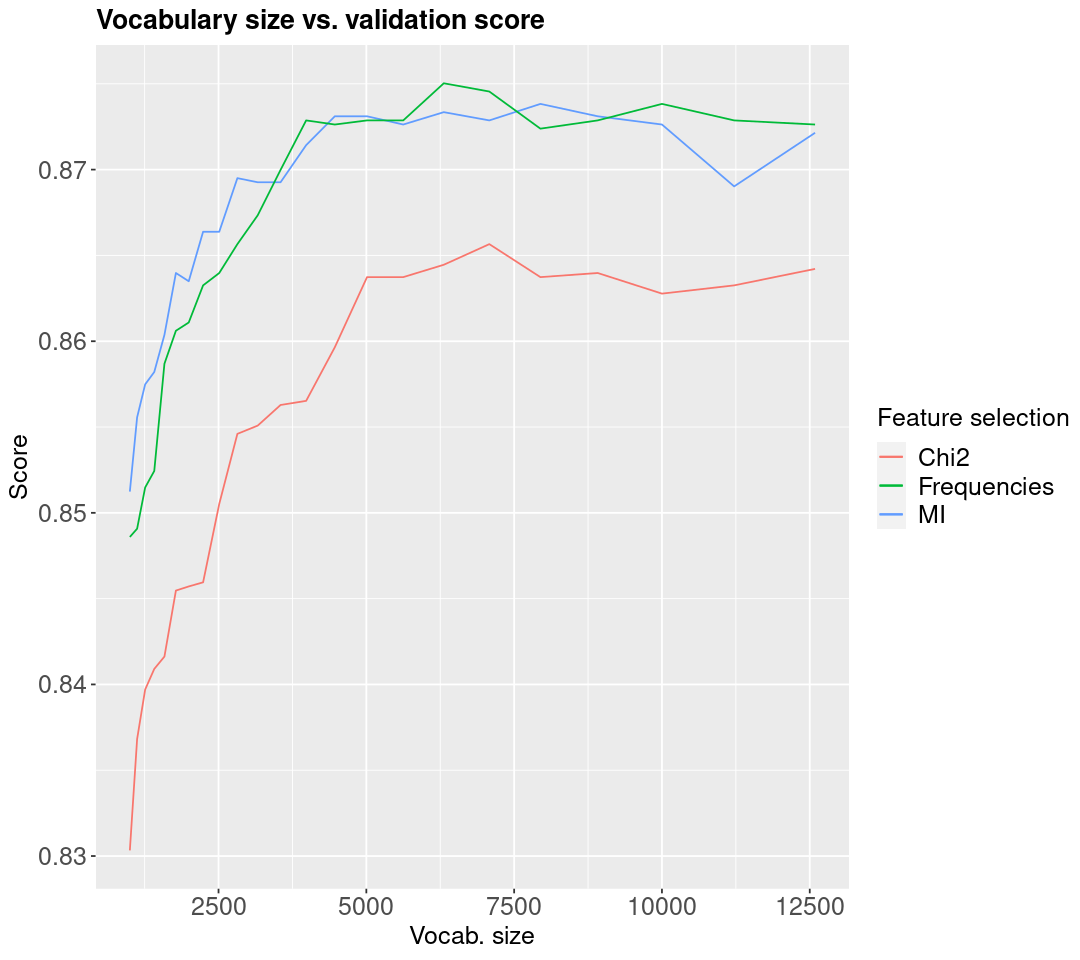

In [60]:
#Plot theme
options(repr.plot.width=9, repr.plot.height=8)

theme <- theme(legend.text = element_text(size = 15), axis.title = element_text(size = 15), axis.text = element_text(size = 15), 
               plot.title = element_text(face = "bold", size = 16), legend.title = element_text(size=15))


#Plot scores as a function of vocabulary size
grafico.scores <- ggplot() + geom_line(aes(x = scores$'Sizes', y = scores$'Chi', color = "Chi2")) + 
                                geom_line(aes(x = scores$'Sizes', y = scores$'MI', color = "MI")) + 
                                    geom_line(aes(x = scores$'Sizes', y = scores$'Frequencies', color = "Frequencies"))

#Add labels, title etc...
grafico.scores  <- grafico.scores + theme + labs(x = "Vocab. size", y = "Score") + 
                        ggtitle("Vocabulary size vs. validation score") +
                             labs(color = "Feature selection")
#Show
grafico.scores

In [61]:
#Chi2
scores[which.max(scores$"Chi"), c("Sizes", "Chi")]

,Sizes,Chi
,<dbl>,<dbl>
18,7080,0.8656573


In [62]:
#MI
scores[which.max(scores$"MI"), c("Sizes", "MI")]

,Sizes,MI
,<dbl>,<dbl>
19,7944,0.8738284


In [63]:
#Frequencies
scores[which.max(scores$"Frequencies"), c("Sizes", "Frequencies")]

,Sizes,Frequencies
,<dbl>,<dbl>
17,6310,0.87503


### Confusion matrix
We want to plot the confusion matrices, just to check what it is doing.

In [65]:
#Returns predicted labels on validation set
fit <- function(size){
        scores <- rep(0, length(vocab.sizes))
    vocab.short <- vocab.df.order.MI[1:size, ]
    
    #Priors
    p.c <- log(NCs / n.records)

    #Posteriors
    posteriors.df <- vocab.short

    for(class in 0:(Nclasses-1)){
        posteriors.df[, class + 2] <- log(posteriors.df[, class + 2] / sum(posteriors.df[, class + 2]))
    } 
    
    
    #Make predictions
    predictions <- rep(0, length(validation.df$Text))
    for(i in 1:length(validation.df$Text)){
        record <- validation.df$Text[i]
        words <- str_split_1(plain(record), " ") 
        posteriors <- rep(0, Nclasses) #Posterior probabilities (we want to find the maximum)
        for(class in 0:(Nclasses - 1)){
            #For each class evaluate posterior
            posterior <- p.c[class + 1]
            for(word in words){
                #Check if word in vocabulary
                if(word %in% posteriors.df$Token){
                    posterior <- posterior + posteriors.df[which(posteriors.df$Token == word) , class + 2]
                }
            }
            posteriors[class + 1] <- posterior
        }

        predictions[i] <- which.max(posteriors) - 1
    }
    
    return(predictions)
}

In [66]:
best.size <- scores[which.max(scores$"Frequencies"), ]$"Sizes"  
fit.best <- fit(best.size)

In [67]:
best.size

[1] 6310

In [68]:
#Compute confusion matrix on validation set
label.names <- c("True", "False")
cm <- table(validation.df$Labels, fit.best)
row.sums <- rowSums(cm)
cm <- cm / row.sums
cm <- as.data.frame(cm)

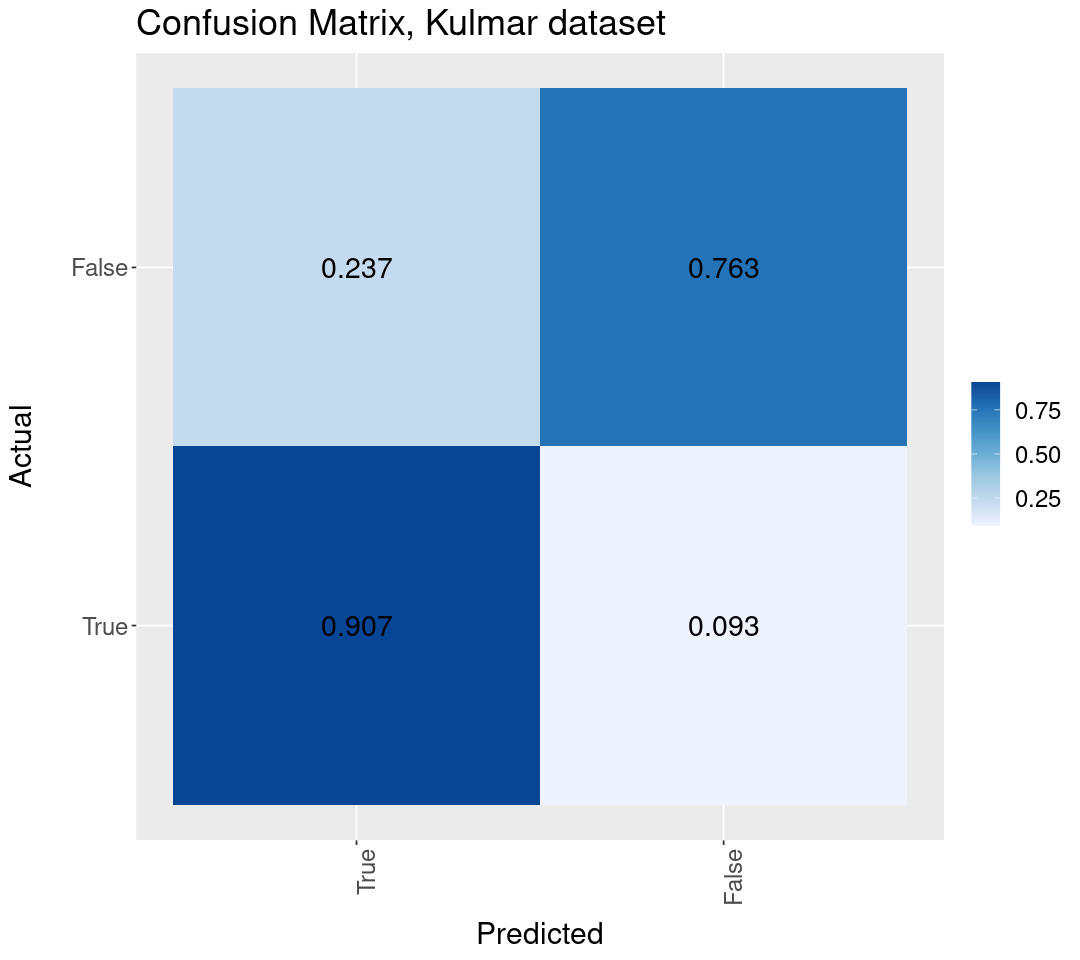

In [69]:
#Plot confusion matrix
options(repr.plot.width=9, repr.plot.height=8)


confusion.plot <- ggplot(cm, aes(x = fit.best, y = Var1, fill = Freq)) +
      geom_tile() + scale_fill_distiller(palette = "Blues", direction = +1) + 
  labs(title = "Confusion Matrix, Kulmar dataset", x = "Predicted", y = "Actual", fill = NULL) + 
geom_text(aes(label = round(Freq, digits = 3)), color = "black", size = 6)

confusion.plot +
    theme(text = element_text(size=18),
        axis.text.x = element_text(angle=90, hjust=1)) +
          theme(axis.title.x = element_text(margin = margin(t = 10, r = 20, b = 0, l = 0)))+
              theme(axis.title.y = element_text(margin = margin(t = 0, r = 20, b = 0, l = 0))) + 
                    scale_x_discrete(labels = label.names) + scale_y_discrete(labels = label.names)